# Assignment 5 - Model Tuning, Evaluation & Ensemble Learning

## Wang Yuli 3035028946

This assignment has weighting $1.5$.

# Model tuning and evaluation

In [1]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Dataset

We will use the Wisconsin breast cancer dataset for the following questions

In [2]:
import pandas as pd

wdbc_source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
#wdbc_source = '../datasets/wdbc/wdbc.data'

df = pd.read_csv(wdbc_source, header=None)

In [3]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M', 'B'])

array([1, 0])

In [4]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20, random_state=1)

In [5]:
%matplotlib inline

# K-fold validation (20 points)

Someone wrote the code below to conduct cross validation.
Do you see anything wrong with it?
And if so, correct the code and provide an explanation.

In [9]:
import numpy as np
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline

if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold

scl = StandardScaler()
pca = PCA(n_components=2)
clf = Perceptron(random_state=1)

# data preprocessing
X_train_std = scl.fit_transform(X_train)
X_test_std = scl.transform(X_test)

X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# compute the data indices for each fold
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

num_epochs = 2
scores = []

enumerate_kfold = list(enumerate(kfold))
for epoch in range(num_epochs):
    for k, (train, test) in enumerate_kfold:
        clf.fit(X_train_std[train], y_train[train])
        score = clf.score(X_train_std[test], y_train[test])
        scores.append(score)
        print('Epoch: %s, Fold: %s, Class dist.: %s, Acc: %.3f' % (epoch,
                                                                   k, 
                                                                   np.bincount(y_train[train]),
                                                                   score))
    print('')
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Epoch: 0, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 0, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 0, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 0, Fold: 4, Class dist.: [256 153], Acc: 0.957
Epoch: 0, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 0, Fold: 6, Class dist.: [257 153], Acc: 0.933
Epoch: 0, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 8, Class dist.: [257 153], Acc: 0.978
Epoch: 0, Fold: 9, Class dist.: [257 153], Acc: 0.978

Epoch: 1, Fold: 0, Class dist.: [256 153], Acc: 0.913
Epoch: 1, Fold: 1, Class dist.: [256 153], Acc: 0.978
Epoch: 1, Fold: 2, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 3, Class dist.: [256 153], Acc: 0.935
Epoch: 1, Fold: 4, Class dist.: [256 153], Acc: 0.957
Epoch: 1, Fold: 5, Class dist.: [257 153], Acc: 1.000
Epoch: 1, Fold: 6, Class dist.: [257 153], Acc: 0.933
Epoch: 1, Fold: 7, Class dist.: [257 153], Acc: 0.978
Epoch: 1, Fold: 8, Class di

## Answer


#### Code change: 

<font color = 'red'><b>-</b></font> ```clf.partial_fit(X_train_std[train], y_train[train], classes=np.unique(y_train))```
<font color = 'blue'><b>+</b></font> ```clf.fit(X_train_std[train], y_train[train])```

#### Explanation: the problem

* First of all, the 2 epochs should give the exact same output, since we are doing exactly the same thing in both epochs: cross validation using 10 folds
* The original code gives different output for the 2 epochs

#### Explanation: reason & changes made

* The problem is because of ```partial_fit()```, which is a cumulative training method without resetting model parameters in each fold.
* However, what we want to do is to use 10 seperate models for the 10 folds in order to get averaged performance of a same set of hyper-parameters.
* Therefore, we should use ```fit()``` instead, which reset model parameters in each fold.

# Precision-recall curve (40 points)

We have plotted ROC (receiver operator characteristics) curve for the breast cancer dataset.

Plot the precision-recall curve for the same data set using the same experimental setup.
What similarities and differences you can find between ROC and precision-recall curves?

You can find more information about precision-recall curve online such as: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

# Answer

## Code

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
from sklearn.linear_model import LogisticRegression

# build pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])
# cross-validation
if Version(sklearn_version) < '0.18':
    cv = StratifiedKFold(y_train, 
                         n_folds=3, 
                         random_state=1)
    
else:
    cv = list(StratifiedKFold(n_splits=3, 
                              random_state=1).split(X_train, y_train))
    

### ROC (receiver operator characteristics) curve plotting

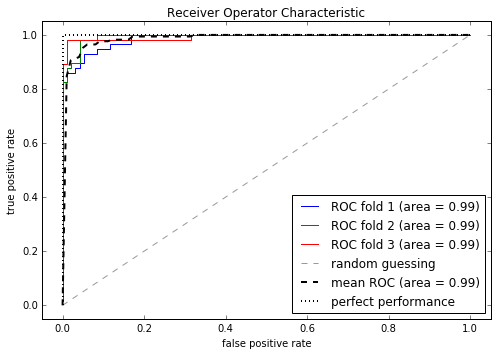

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# plot the 3 folds
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    #mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

# plot worst: random guessing
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# plot mean of the 3 folds
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)

# plot best: perfect performance
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

### Precision-recall curve plotting

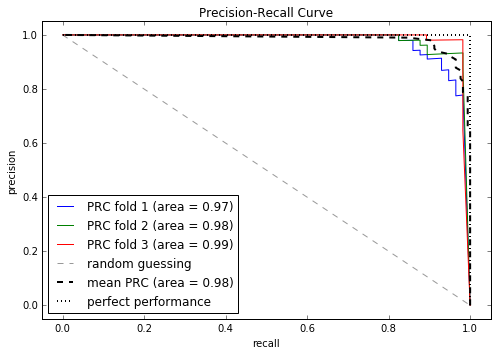

In [50]:
from sklearn.metrics import precision_recall_curve

fig = plt.figure(figsize=(7, 5))

mean_recall = 0.0
mean_precision = np.linspace(0, 1, 100)
all_recall = []

# plot the 3 folds
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train[train],
                         y_train[train]).predict_proba(X_train[test])
    precision, recall, thresholds = precision_recall_curve(
                                    y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_recall += interp(mean_precision, precision, recall)
    precision[0] = 0.0
    pr_auc = auc(recall, precision)
    plt.plot(recall,
             precision,
             lw=1,
             label='PRC fold %d (area = %0.2f)'
                   % (i+1, pr_auc))

# plot worst: random guessing
plt.plot([0, 1],
         [1, 0],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# plot mean of the 3 folds
mean_recall /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='mean PRC (area = %0.2f)' % mean_auc, lw=2)

# plot best: perfect performance
plt.plot([0, 1, 1],
         [1, 1, 0],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
# plt.savefig('./figures/prc.png', dpi=300)
plt.show()

## Explanation: 

similarities & differences of the 2 plots above

The two plots above are axial symmmetric in shape. Both curve presents a model close to the ideal performances.

The reason behind is that ROC's ideal is to achieve a model where: no matter how FPR changes, TPR will always be close to 100%, therefore we got the plot as above.

For precision-recall curve, by definition we know that precision and recall is more like a trade-off:

$$
precision = \frac{TP}{TP+FP}
$$

$$
recall = TPR = \frac{TP}{TP+FN}
$$

e.g. suppose we have really small threshold, the precison can be really good, but the recall can be really bad in that case

Hence, 

Worst performance: the random guessing, where when we increase precison, the recall decreases. When we have really good recall, the precision will be really bad

Best performance: no matter how recall changes, the precision will always be close to 100%, which means no matter how many class-1 items correctly predicted out of all truly class-1 items, the predicted class-1 items are all acurrate (in deed class-1)

Therefore, the two plots will show the same level of how good is our model, since they are using the exact same steps to train.


# Ensemble learning

We have used the following code to compute and plot the ensemble error from individual classifiers for binary classification:

In [51]:
from scipy.misc import comb
import math
import numpy as np

def ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) for k in range(k_start, num_classifier+1)]
    return sum(probs)

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
def plot_base_error(ensemble_error_func, num_classifier, error_delta):

    error_range = np.arange(0.0, 1+error_delta, error_delta)
    ensemble_errors = [ensemble_error_func(num_classifier=num_classifier, base_error=error) for error in error_range]

    plt.plot(error_range, ensemble_errors, 
             label = 'ensemble error',
             linewidth=2)
    plt.plot(error_range, error_range,
             label = 'base error',
             linestyle = '--',
             linewidth=2)
    plt.xlabel('base error')
    plt.ylabel('base/ensemble error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [54]:
num_classifier = 11
error_delta = 0.01
base_error = 0.25

In [55]:

print(ensemble_error(num_classifier=num_classifier, base_error=base_error))


0.034327507019


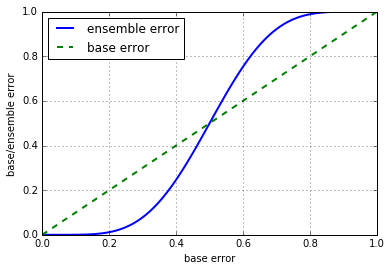

In [56]:
plot_base_error(ensemble_error, num_classifier=num_classifier, error_delta=error_delta)

# Number of classifiers (40 points)

The function plot_base_error() above plots the ensemble error as a function of the base error given a fixed number of classifiers.

Write another function to plot ensembe error versus different number of classifiers with a given base error.

Does the ensemble error always go down with more classifiers? 
Why or why not?

Can you improve the method ensemble_error() to produce a more reasonable plot?

## Answer

The code for plotting is below:

In [90]:
def plot_num_classifier(ensemble_error_func, max_num_classifier, base_error):
    # your code here
    classifier_range = np.arange(1, max_num_classifier+1)
    ens_errors = [ensemble_error_func(num_classifier=n, base_error=base_error)
                 for n in classifier_range]
    
    plt.plot(classifier_range, 
             ens_errors, 
             label='Ensemble error', 
             linewidth=2)
    
    plt.plot(classifier_range, 
             np.repeat(base_error, 20), 
             linestyle='--',
             label='Base error',
             linewidth=2)
    plt.xlabel('# of classifiers')
    plt.ylabel('Base/Ensemble error')
    plt.legend(loc='upper right')
    plt.grid()
    plt.tight_layout()
    # plt.savefig('./figures/ensemble_err.png', dpi=300)
    plt.show()

State your observations of the experiments of your code...

In [99]:
max_num_classifiers = 20
base_error = 0.25

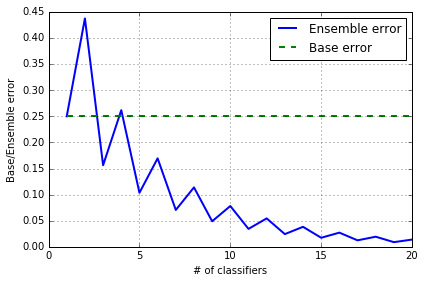

In [100]:
plot_num_classifier(ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

Explain your observations above.

Describe a better algorithm for computing the ensemble error.

## Explanation for above plot

The ensemble error doesn't always go down with more classifiers. Here is my underdtanding and algorithm designed to produce a more reasonable plot

### Mathematically 

For equation 

$$
\epsilon_{ensemble} (K)= 
\sum_{k=K}^n C\left(n, k\right) \epsilon^k \left(1-\epsilon\right)^{n-k}
$$

when n is small, we know term $C\left(n, k\right)$ is dominant compared to the error ratio. Since $2m$ classifiers has 1 more polynomial term in summation than $2m-1$ classifiers (where $m = 1,2,3...$), it is normal to see an increasing trend from $2m$ to $2m-1$, despite the fact that the overall trend is still decreasing.

### However, there is also foundamental reasons behind that

There are actually 3 main reasons why the above ```ensemble_error()``` function doesn't make sense:

1. for $n$ classifiers, cases that $\left\lceil \frac{n}{2} \right\rceil$ of them vote wrong or $n$ of them all vote wrong should be considered differently in the levels of importance. Therefore, confidence scores (weights) should be taken into consideration for the votes
2. how many classifiers we have in total can also be taken into consideration in the confidence. It shouldn't be large in our new function, since it is also what we want to prove. But it can still be used to break tie to produce a more realistic plot (shown in the 2 plots below). 
3. the start point for k is also not accurate. for example, when $n = 2m$ then $\left\lceil \frac{n}{2} \right\rceil = m$. However, we need the cumulative voting to be -1 for a misclassification. Therefore, we can also introduce a minor change: if $n = 2m$ then $k_{start} = \left\lceil \frac{n}{2} \right\rceil +1$

References for the 3 points above: ch07 of this course, [confidence estimation](http://www.scholarpedia.org/article/Ensemble_learning#Confidence_Estimation), [voting based methods](http://www.scholarpedia.org/article/Ensemble_learning#Voting_based_methods)

### Finally, the algorithm:
* change k_start:

$$
k_{start} = 
\begin{cases}
\left\lceil \frac{n}{2} \right\rceil +1 \; if \; n = 2m\\
\left\lceil \frac{n}{2} \right\rceil \; otherwise
\end{cases}
$$

* change the way to compute ensemble error:
$$
\begin{align}
\epsilon_{ensemble} (K)
&= 
\sum_{k=K}^n C\left(n, k\right) \epsilon^k \left(1-\epsilon\right)^{n-k} \frac{2k-n}{n-k+1}
\end{align}
$$

where $\frac{2k-n}{n-k+1}$ or $\frac{k-(n-k)}{n-k+1}$is the confidence score (weight), considering 
1. importance of how many classifiers in total ($n$)
2. relative importance of each $k$ with respect to $n$

Molecular $k-(n-k)$: how dominant the number k is, compared with n-k

Denominator $n-k+1$: instead of simple $n$ as the denominator, use this to break tie of equal cumulative errors, by considering different numbers of classifiers

In [205]:
def better_ensemble_error_with_tie(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    if(k_start == num_classifier/2):
        k_start += 1
    # print('%d classifier, need %d votes to be wrong decision' % (num_classifier, k_start))
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) 
             * (2*k-num_classifier)/(num_classifier) # confidence
             for k in range(k_start, num_classifier+1)]
    # print(sum(probs))
    return sum(probs)

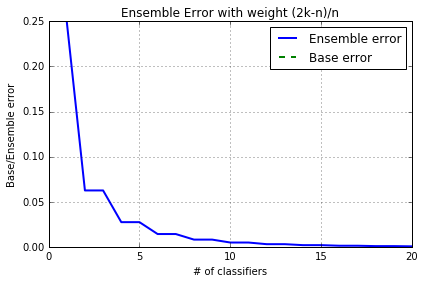

In [210]:
plt.title('Ensemble Error with weight (2k-n)/n')
plot_num_classifier(better_ensemble_error_with_tie, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)

### Breaking Tie...
* the above plot has ties because we use exact $\frac{2k-n}{n}$ as weights, which makes the results of the equation to be exactly the same for $n=2m+1$ & $n=2m$ (where m = 1,2,3...)
* But in reality, the weighting might not be exactly $\frac{2k-n}{n}$. Therefore, we use $\frac{2k-n}{n-k+1}$ as an example to see how the curve will really be like

In [207]:
def better_ensemble_error(num_classifier, base_error):
    k_start = math.ceil(num_classifier/2)
    if(k_start == num_classifier/2):
        k_start += 1
    # print('%d classifier, need %d votes to be wrong decision' % (num_classifier, k_start))
    probs = [comb(num_classifier, k)*(base_error**k)*((1-base_error)**(num_classifier-k)) 
             * (2*k-num_classifier)/(num_classifier-k+1) # confidence
             for k in range(k_start, num_classifier+1)]
    # print(sum(probs))
    return sum(probs)

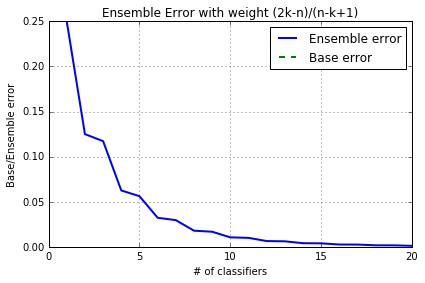

In [211]:
plt.title('Ensemble Error with weight (2k-n)/(n-k+1)')
plot_num_classifier(better_ensemble_error, 
                    max_num_classifier=max_num_classifiers, 
                    base_error=base_error)